# 实验说明

## 作业说明

### 目标：

训练一个玩2048的神经网络，并得到较高的准确率。

### 背景：

2048是一个益智小游戏，规则为：控制所有方块向同一个方向运动，两个相同数字方块撞在一起后合并，成为他们的和。每次操作时会随机生成一个2或者4，最终得到一个“2048”的方块就算胜利。规则的直观解释：[Click to Play 2048](https://play2048.co/)

本教程展示如何训练一个玩2048的神经网络模型，并评估其最终能够得到的分数。

#### 建模过程：

2048游戏可以理解为一个这样的过程：

<blockquote>
    
有一个**局面（state）**，4x4格子上的一些数字。
    
<img src="https://data.megengine.org.cn/megstudio/images/2048_demo.png" width=256 height=256 />

你可以选择做一些**动作（action）**，比如按键盘上的上/下/左/右键。

你有一些**策略（policy）**，比如你觉得现在按左最好，因为这样有两个8可以合并。对于每个动作，可以用一个打分函数来决定你的策略。

在按照策略做完动作之后，你会得到一个**奖励（reward）**，比如因为两个8合并，分数增加了16，这个16可以被看作是这一步的奖励。

在许多步之后，游戏结束，你会得到一个**回报（return）**，即游戏的最终分数。

</blockquote>

由此，我们将2048建模为一个马尔可夫决策过程，其求解可以通过各种强化学习方法来完成。在baseline中，我们使用了 [Double DQN](https://arxiv.org/abs/1509.06461)。

### 任务：

Q1：训练模型

运行baseline，训练和评估模型。观察游戏结束时的滑动平均分数。你可以调用`print_grid`函数输出模型玩游戏的过程，以判断模型是否可以得到合理的结果。
提供参考数据：纯随机游玩，平均分数约为570分。在baseline的训练过程中，模型最高可以达到8000分，平均为2000分左右。

请你修改参数，模型结构等，使得游戏的平均分数尽可能地高。请注意：这里的平均分数指每个游戏结束**最终分数**的平均值。
**请于q1.diff提交你的代码。**

## 数据集

2048游戏代码来源：[console2048](https://github.com/Mekire/console-2048/blob/master/console2048.py)

## 文件存储
实验中生成的文件可以存储于 workspace 目录中。 查看工作区文件，该目录下的变更将会持久保存。 您的所有项目将共享一个存储空间，请及时清理不必要的文件，避免加载过慢。

## 实验步骤

1.导入库

In [1]:
import megengine as mge
import numpy as np 
import megengine.module as M
import megengine.functional as F
import megengine.data.transform as T
from random import random, randint, shuffle, sample
from megengine.optimizer import Adam
from megengine.autodiff import GradManager
from megengine import tensor
from tqdm import tqdm
import time
import os
# import torch
import pickle as pickle

2.2048游戏函数

In [2]:
# https://github.com/Mekire/console-2048/blob/master/console2048.py

def push_left(grid):
    moved, score = False, 0
    rows, columns = grid.shape[0], grid.shape[1]
    for k in range(rows):
        i, last = 0, 0
        for j in range(columns):
            e = grid[k, j]
            if e:
                if e == last:
                    grid[k, i-1]+=e
                    score += e
                    last, moved = 0, True
                else:
                    moved |= (i != j)
                    last=grid[k, i]=e
                    i+=1
        while i<columns:
            grid[k,i]=0
            i+=1
    return score if moved else -1

def push_right(grid):
    moved, score = False, 0
    rows, columns = grid.shape[0], grid.shape[1]
    for k in range(rows):
        i = columns-1
        last  = 0
        for j in range(columns-1,-1,-1):
            e = grid[k, j]
            if e:
                if e == last:
                    grid[k, i+1]+=e
                    score += e
                    last, moved = 0, True
                else:
                    moved |= (i != j)
                    last=grid[k, i]=e
                    i-=1
        while 0<=i:
            grid[k, i]=0
            i-=1
    return score if moved else -1

def push_up(grid):
    moved,score = False, 0
    rows, columns = grid.shape[0], grid.shape[1]
    for k in range(columns):
        i, last = 0, 0
        for j in range(rows):
            e = grid[j, k]
            if e:
                if e == last:
                    score += e
                    grid[i-1, k]+=e
                    last, moved = 0, True
                else:
                    moved |= (i != j)
                    last=grid[i, k]=e
                    i+=1
        while i<rows:
            grid[i, k]=0
            i+=1
    return score if moved else -1

def push_down(grid):
    moved, score = False, 0
    rows, columns = grid.shape[0], grid.shape[1]
    for k in range(columns):
        i, last = rows-1, 0
        for j in range(rows-1,-1,-1):
            e = grid[j, k]
            if e:
                if e == last:
                    score += e
                    grid[i+1, k]+=e
                    last, moved = 0, True
                else:
                    moved |= (i != j)
                    last=grid[i, k]=e
                    i-=1
        while 0<=i:
            grid[i, k]=0
            i-=1
    return score if moved else -1

def push(grid, direction):
    if direction&1:
        if direction&2:
            score = push_down(grid)
        else:
            score = push_up(grid)
    else:
        if direction&2:
            score = push_right(grid)
        else:
            score = push_left(grid)
    return score


def put_new_cell(grid):
    n = 0
    r = 0
    i_s=[0]*16
    j_s=[0]*16
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if not grid[i,j]:
                i_s[n]=i
                j_s[n]=j
                n+=1
    if n > 0:
        r = randint(0, n-1)
        grid[i_s[r], j_s[r]] = 2 if random() < 0.9 else 4
    return n

def any_possible_moves(grid):
    """Return True if there are any legal moves, and False otherwise."""
    rows = grid.shape[0]
    columns = grid.shape[1]
    for i in range(rows):
        for j in range(columns):
            e = grid[i, j]
            if not e:
                return True
            if j and e == grid[i, j-1]:
                return True
            if i and e == grid[i-1, j]:
                return True
    return False



def prepare_next_turn(grid):
    """
    Spawn a new number on the grid; then return the result of
    any_possible_moves after this change has been made.
    """
    empties = put_new_cell(grid)    
    return empties>1 or any_possible_moves(grid)


def print_grid(grid_array):
    """Print a pretty grid to the screen."""
    print("")
    wall = "+------"*grid_array.shape[1]+"+"
    print(wall)
    for i in range(grid_array.shape[0]):
        meat = "|".join("{:^6}".format(grid_array[i,j]) for j in range(grid_array.shape[1]))
        print("|{}|".format(meat))
        print(wall)


class Game:
    def __init__(self, cols=4, rows=4):
        self.grid_array = np.zeros(shape=(rows, cols), dtype='uint16')
        self.grid = self.grid_array
        for i in range(2):
            put_new_cell(self.grid)
        self.score = 0
        self.end = False
    
    def copy(self):
        rtn = Game(self.grid.shape[0], self.grid.shape[1])
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                rtn.grid[i,j]=self.grid[i,j]
        rtn.score = self.score
        rtn.end = self.end
        return rtn

    def max(self):
        m = 0
        for i in range(self.grid.shape[0]):
            for j in range(self.grid.shape[1]):
                if self.grid[i,j]>m:
                    m = self.grid[i,j]
        return m
        

    def move(self, direction):
        if direction&1:
            if direction&2:
                score = push_down(self.grid) # 3
            else:
                score = push_up(self.grid) # 1
        else:
            if direction&2:
                score = push_right(self.grid) # 2
            else:
                score = push_left(self.grid) # 0
        if score == -1:
            return 0
        self.score += score
        if not prepare_next_turn(self.grid):
            self.end = True
        return 1

    def display(self):
        print_grid(self.grid_array)

def random_play(game):
    moves = [0,1,2,3]
    while not game.end:
        shuffle(moves)
        for m in moves:
            if game.move(m):
                    break    
    return game.score

3.定义记忆回放类并实例化

在记录一次决策过程后，我们存储到该类中，并在训练时选择一部分记忆进行训练。

In [3]:
# https://github.com/megvii-research/ICCV2019-LearningToPaint/blob/master/baseline/DRL/rpm.py

class rpm(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []
        self.index = 0
        
    def append(self, obj):
        if self.size() > self.buffer_size:
            print('buffer size larger than set value, trimming...')
            self.buffer = self.buffer[(self.size() - self.buffer_size):]
        elif self.size() == self.buffer_size:
            self.buffer[self.index] = obj
            self.index += 1
            self.index %= self.buffer_size
        else:
            self.buffer.append(obj)

    def size(self):
        return len(self.buffer)

    def sample_batch(self, batch_size):
        if self.size() < batch_size:
            batch = sample(self.buffer, self.size())
        else:
            batch = sample(self.buffer, batch_size)

        res = []
        for i in range(5):
            k = F.stack(tuple(item[i] for item in batch), axis=0)
            res.append(k)
        return res[0], res[1], res[2], res[3], res[4]

data = rpm(10000)

4.定义模型结构

In [4]:
class Net(M.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = M.Conv2d(16, 256, kernel_size=(2, 1), stride=1, padding=0)
        self.relu0 = M.ReLU()
        self.conv1 = M.Conv2d(256, 256, kernel_size=(1, 2), stride=1, padding=0)
        self.relu1 = M.ReLU()
        self.conv2 = M.Conv2d(256, 256, kernel_size=(2, 1), stride=1, padding=0)
        self.relu2 = M.ReLU()
        self.conv3 = M.Conv2d(256, 256, kernel_size=(1, 2), stride=1, padding=0)
        self.relu3 = M.ReLU()
        self.fc1 = M.Linear(1024, 16)
        self.relu5 = M.ReLU()
        self.fc2 = M.Linear(16, 3)

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu0(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = F.flatten(x,1)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.fc2(x)
        x = F.reshape(x,(-1,3))
        return x

model = Net()
model_target = Net()

5.定义输入转化函数，使得局面可以被输入进模型。

In [5]:
table = {2**i:i for i in range(1,16)}
table[0] = 0

def make_input(grid):
    g0 = grid
    r = np.zeros(shape=(16, 4, 4), dtype=np.float32)
    for i in range(4):
        for j in range(4):
            v = g0[i, j]
            r[table[v],i, j]=1
    return r

6.定义优化器

In [6]:
opt = Adam(model.parameters(), lr = 1e-4)

7.模型训练

epoch:  86%|████████▌ | 42819/50000 [32:16<05:20, 22.38it/s, loss=0.02330, Q=4.18124, reward=4.37500, avg_score=2282.81757] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

epoch: 100%|██████████| 50000/50000 [37:43<00:00, 23.51it/s, loss=0.04814, Q=4.38851, reward=2.93750, avg_score=2566.86205] 

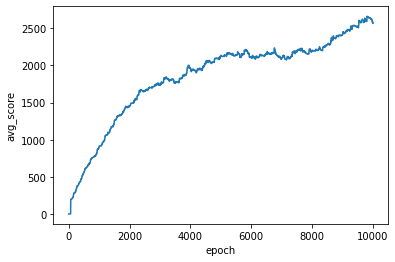

epoch: 100%|██████████| 50000/50000 [37:43<00:00, 22.09it/s, loss=0.04814, Q=4.38851, reward=2.93750, avg_score=2566.86205]

maxscore:7050
avg_score:2566.8620541415057


In [7]:
import matplotlib.pyplot as plt

maxscore = 0
avg_score = 0
epochs = 10000

game = []
epoch_list = []
score_list = []

'''Play 32 games at the same time'''
for i in range(32):
    game.append(Game())

with tqdm(total=epochs*5, desc="epoch") as tq:
    for epoch in range(epochs):
        epoch_list.append(epoch)
        
        '''double DQN'''
        if epoch % 10 == 0:
            mge.save(model, "1.mge")
            model_target = mge.load("1.mge") 
            
        grid = []
        for k in range(32):
            
            '''Check if the game is over'''
            if any_possible_moves(game[k].grid) == False:
                if avg_score == 0:
                    avg_score = game[k].score
                else:
                    avg_score = avg_score * 0.99 + game[k].score * 0.01
                game[k] = Game()
        
            tmp = make_input(game[k].grid)
            grid.append(tensor(tmp))
            
        status = F.stack(grid, 0)
        
        '''Choose the action with the highest probability'''
        a = F.argmax(model(status).detach(), 1)
        a = a.numpy()
        
        for k in range(32):
            pre_score = game[k].score
            pre_grid = game[k].grid.copy()
            game[k].move(a[k])
            after_score = game[k].score
            if game[k].score > maxscore:
                maxscore = game[k].score
            action = a[k]
            
            '''In some situations, some actions are meaningless, try another'''
            while (game[k].grid == pre_grid).all():
                action = (action + 1) % 4
                game[k].move(action)
            
            score = after_score - pre_score
            done = tensor(any_possible_moves(game[k].grid) == False)
            grid = tensor(make_input(game[k].grid.copy()))
            
            '''Record to memory'''
            '''(status, next_status, action, score, if_game_over)'''
            data.append((tensor(make_input(pre_grid)), tensor(grid), tensor(a[k]),tensor(score / 128), done))
            
        for i in range(5):
            gm = GradManager().attach(model.parameters())
            with gm:
                s0, s1, a, reward, d = data.sample_batch(32)
                
                '''double DQN'''
                pred_s0 = model(s0)
                pred_s1 = F.max(model_target(s1), axis=1)
                
                loss = 0
                total_Q = 0
                total_reward = 0
                for i in range(32):
                    Q = pred_s0[i][a[i]]
                    total_Q += Q
                    total_reward += reward[i]
                    loss += F.loss.square_loss(Q, pred_s1[i].detach() * 0.99 * (1 - d[i]) + reward[i])
                loss /= 32
                total_Q /= 32
                total_reward = total_reward / 32 * 128
                tq.set_postfix(
                            {
                                "loss": "{0:1.5f}".format(loss.numpy().item()),
                                "Q": "{0:1.5f}".format(total_Q.numpy().item()),
                                "reward": "{0:1.5f}".format(total_reward.numpy().item()),
                                "avg_score":"{0:1.5f}".format(avg_score),
                            }
                        )
                tq.update(1)
                gm.backward(loss)

            opt.step()
            opt.clear_grad()

        score_list.append(avg_score)

    plt.plot(epoch_list, score_list)
    plt.xlabel("epoch")
    plt.ylabel("avg_score")
    plt.show()

print("maxscore:{}".format(maxscore))
print("avg_score:{}".format(avg_score))